## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Define the files to be loaded

In [2]:
# Participant number whose data should be loaded
participant_number = 2

# The version of the questionnaires to load
quest_version = 2

## Loading the pre-processed data

In [3]:
df = pd.read_csv('data/preprocessed/preprocessed_data_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df = df.drop(labels=['actual_day', 'actual_day.1'], axis=1)

df_oura = pd.read_csv('data/preprocessed/preprocessed_sleep_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_oura = df_oura.drop(labels=['actual_day'], axis=1)

df_quest = pd.read_csv('data/preprocessed/preprocessed_questionnaires_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_quest = df_quest.drop(labels=['actual_day'], axis=1)

In [4]:
# Remove these to try and fix the issues raised by LazyRegressor for them 
# example: 
# AdaBoostRegressor model failed to execute
# Found unknown categories ['[0.0, 51.0, 53.0, 53.0, 54.0, 53.0, ...
df = df.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)
df_oura = df_oura.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)

In [5]:
# Replace NaN values by 999 because NaN values can raise errors when fed to a regression model
df.fillna(999, inplace=True)
df_oura.fillna(999, inplace=True)
df_quest.fillna(999, inplace=True)

In [6]:
# Check for variables whose values are stored as string. This cannot be analyzed by the regression model
for i in range(len(df.columns)):
    if isinstance(df.iloc[1,i], str):
        print('column ' + df.columns[i])
        print('     ' + df.iloc[1,i])

## Apply Lasso

In [7]:
# Separate the indenpendent variables from the dependent variables
y = df['subjective_sleep_score']
X = df.drop(labels=['score', 'subjective_sleep_score'], axis=1)
X_oura = df_oura.drop(labels=['score'], axis=1)
X_quest = df_quest

In [8]:
def lasso_model(X, y, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

    reg = Lasso(alpha=0.1)
    reg.fit(X_train, y_train)

    print("Number of coefficients", len(reg.coef_))
    print("Non-zero coeffcients", np.count_nonzero(reg.coef_))
    print("Coefficients", reg.coef_)
    return reg, X_train, X_test, y_train, y_test 

In [9]:
# Compute R squared and mean square error of a given model and training and testing sets 
def compute_model(model, X_train, y_train, X_test, y_test):
    print('R squared training set', round(model.score(X_train, y_train), 3))
    print('R squared test set', round(model.score(X_test, y_test), 3))

    # Training data
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 3))

    # Test data
    pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 3))

    return pred_train, pred_test

### Using as independent variables all variables (Oura + questionnaire data)

In [10]:
reg, X_train, X_test, y_train, y_test = lasso_model(X, y, random_state=np.random.randint(50000))

Number of coefficients 78
Non-zero coeffcients 31
Coefficients [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.43074956e-03  1.15211355e-04 -1.52962639e-05 -0.00000000e+00
 -7.92200493e-05 -8.58107184e-18 -5.47182114e-03 -0.00000000e+00
  3.35507353e-02  7.79972289e-04 -0.00000000e+00 -1.11448545e-02
 -2.59067893e-02  2.03963595e-04 -0.00000000e+00  0.00000000e+00
 -7.56440250e-04  1.92317604e-04  0.00000000e+00 -5.08405939e-05
 -0.00000000e+00  0.00000000e+00 -1.27130966e-02 -1.15385624e-02
  2.59382457e-04  0.00000000e+00  2.06920658e-03  8.43631131e-03
  0.00000000e+00  0.00000000e+00  2.81183420e-02 -0.00000000e+00
  1.82715362e-04 -0.00000000e+00  3.33773004e-02  3.90188372e-04
 -1.52988210e-04 -3.77829645e-04 -2.59865943e-06 -0.00000000e+00
  2.68712500e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.0000000

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e+00, tolerance: 7.468e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [11]:
pred_train, pred_test = compute_model(reg, X_train, y_train, X_test, y_test)

R squared training set 0.718
R squared test set -19.103
MSE training set 0.274
MSE test set 12.615


### Visualizing the results

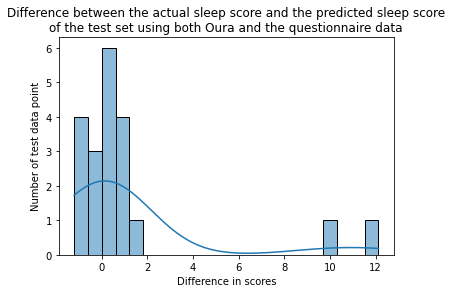

In [12]:
ax = sns.histplot(y_test-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data point', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using both Oura and the questionnaire data')
plt.show()

## Apply LassoCV
### Using as independent variables all variables (Oura + questionnaire data)

In [13]:
lasso_cv = LassoCV(alphas=np.arange(0.01, 5, 0.01), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

print('Best alpha:', lasso_cv.alpha_)
pred_train, pred_test = compute_model(lasso_cv, X_train, y_train, X_test, y_test)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e+00, tolerance: 5.308e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e+00, tolerance: 5.308e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might wan

Best alpha: 4.99
R squared training set 0.564
R squared test set 0.071
MSE training set 0.423
MSE test set 0.583


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.242e-01, tolerance: 5.639e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+00, tolerance: 5.639e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might wan

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=10))
sel_.fit(scaler.transform(X_train), y_train)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.254e-01, tolerance: 7.468e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


SelectFromModel(estimator=Lasso(alpha=0.001, random_state=10))

In [15]:
sel_.get_support()

array([False,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True, False, False,  True])

In [16]:
sel_.estimator_.coef_

array([ 0.        ,  0.00944052,  0.05345287, -0.01564848, -0.19477524,
        1.12462923, -0.        , -0.        , -0.        , -0.        ,
       -0.38804824,  0.17647157,  0.14584657, -0.21582542, -0.25926503,
       -0.37024885, -1.38413408,  0.26200934,  0.7496944 ,  0.        ,
       -0.35957711, -0.10555984,  0.18879947, -0.44764049, -0.21244899,
        0.02866942,  0.        , -0.        , -0.08120784,  1.39733141,
        0.11821106,  0.76362077,  0.53079301, -0.71290018,  0.        ,
       -0.36291645, -0.14569808, -0.59327828,  0.52728657,  1.13465006,
        0.        ,  0.12334242, -0.48141894,  0.        ,  0.49233507,
       -0.        ,  0.0841041 , -0.00477621, -0.07793144,  0.15303167,
        0.09852564, -0.        , -0.15185491, -0.00186533,  0.        ,
        0.35290938, -0.        , -0.03497509, -0.25201292, -0.1099108 ,
       -0.08033931,  0.03132272, -0.24375434,  0.00665985,  0.12994393,
        0.37263595,  0.05579796, -0.0083249 ,  0.35893031,  0.  

In [17]:
print(sel_.get_feature_names_out())
print(len(sel_.get_feature_names_out()))

['x1' 'x2' 'x3' 'x4' 'x5' 'x10' 'x11' 'x12' 'x13' 'x14' 'x15' 'x16' 'x17'
 'x18' 'x20' 'x21' 'x22' 'x23' 'x24' 'x25' 'x28' 'x29' 'x30' 'x31' 'x32'
 'x33' 'x35' 'x36' 'x37' 'x38' 'x39' 'x41' 'x42' 'x44' 'x46' 'x47' 'x48'
 'x49' 'x50' 'x52' 'x53' 'x55' 'x57' 'x58' 'x59' 'x60' 'x61' 'x62' 'x63'
 'x64' 'x65' 'x66' 'x67' 'x68' 'x73' 'x74' 'x77']
57


In [18]:
selected_features = []
for i in range(len(sel_.get_support())):
    if sel_.get_support()[i] == True:
        selected_features.append(X_train.columns[i])

print('Number of selected features', len(selected_features))
selected_features

Number of selected features 57


['average_breath',
 'average_breath_variation',
 'average_heart_rate',
 'average_hrv',
 'awake_time',
 'contributors.deep_sleep',
 'contributors.efficiency',
 'contributors.latency',
 'contributors.rem_sleep',
 'contributors.restfulness',
 'contributors.timing',
 'contributors.total_sleep',
 'deep_sleep_duration',
 'efficiency',
 'latency',
 'light_sleep_duration',
 'lowest_heart_rate',
 'lowest_heart_rate_time_offset',
 'period',
 'readiness.contributors.activity_balance',
 'readiness.contributors.previous_day_activity',
 'readiness.contributors.previous_night',
 'readiness.contributors.recovery_index',
 'readiness.contributors.resting_heart_rate',
 'readiness.contributors.sleep_balance',
 'readiness.score',
 'readiness.temperature_trend_deviation',
 'rem_sleep_duration',
 'restless',
 'restless_periods',
 'sleep_midpoint',
 'timezone',
 'total_sleep_duration',
 'prev_oura_score',
 'Comfort',
 'I stayed in bed trying to sleep',
 'I walked a bit',
 'I went to the toilet',
 'Naturally',

### Using as independent variables only the Oura data
#### Lasso

In [19]:
reg_oura, X_train_oura, X_test_oura, y_train_oura, y_test_oura = lasso_model(X_oura, y, random_state=995)

Number of coefficients 47
Non-zero coeffcients 26
Coefficients [-6.32365172e-03  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -3.99849100e-03  9.30955914e-05 -4.37225967e-05
 -5.38061298e-18 -7.56632280e-05 -0.00000000e+00 -1.61706419e-02
  0.00000000e+00  5.56203444e-02 -0.00000000e+00 -5.01789138e-03
 -0.00000000e+00 -0.00000000e+00  9.20729917e-05  0.00000000e+00
  0.00000000e+00 -1.89801390e-03  6.19592562e-05 -0.00000000e+00
 -3.27610807e-05 -0.00000000e+00  3.04623693e-03  2.22108372e-03
 -2.96493268e-03  0.00000000e+00  0.00000000e+00  5.46007162e-04
  9.30748131e-03  1.43644311e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -8.86998670e-05 -0.00000000e+00  1.37980980e-03
  3.41487324e-04 -1.35437701e-04 -7.66509303e-04 -2.59170326e-05
 -0.00000000e+00  4.80612544e-03 -0.00000000e+00]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.215e+00, tolerance: 6.971e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [20]:
pred_train, pred_test = compute_model(reg_oura, X_train_oura, y_train_oura, X_test_oura, y_test_oura)

R squared training set 0.588
R squared test set 0.38
MSE training set 0.373
MSE test set 0.637


## Applying the same model on the questionnaire data only

In [21]:
reg_quest, X_train_quest, X_test_quest, y_train_quest, y_test_quest = lasso_model(X_quest, y, random_state=995)

Number of coefficients 34
Non-zero coeffcients 6
Coefficients [ 5.42903834e-05 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  8.66540545e-01 -8.28080498e-05 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.17064410e-04  0.00000000e+00 -3.14528798e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.46927292e-06 -0.00000000e+00]


In [22]:
pred_train, pred_test = compute_model(reg_quest, X_train_quest, y_train_quest, X_test_quest, y_test_quest)

R squared training set 0.985
R squared test set 0.988
MSE training set 0.013
MSE test set 0.012
